In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow import keras
import warnings
from tqdm import tqdm
from kaggler.preprocessing import LabelEncoder
from kaggler.model import AutoLGB
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

In [3]:
import kaggler
print(kaggler.__version__)

0.9.3


In [4]:
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
warnings.simplefilter('ignore')

### Load Data

In [5]:
index_col = 'index'
target_col = 'credit'

In [6]:
trn = pd.read_csv('./open/train.csv', index_col=index_col)
print(trn.shape)
trn.head()

(26457, 19)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [7]:
tst = pd.read_csv('./open/test.csv', index_col=index_col)
print(tst.shape)
tst.head()

(10000, 18)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
index,,,,,,,,,,,,,,,,,,
26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [8]:
sub = pd.read_csv('./open/sample_submission.csv', index_col=index_col)
print(sub.shape)
sub.head()

(10000, 3)


,0,1,2
index,,,
26457,0,0,0
26458,0,0,0
26459,0,0,0
26460,0,0,0
26461,0,0,0


### Simple EDA

In [9]:
trn[target_col].value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

In [10]:
for col in trn.columns:
    print(f'{col:>16s}: {trn[col].count()}\t{trn[col].nunique()}\t{trn[col].dtype}')

          gender: 26457	2	object
             car: 26457	2	object
         reality: 26457	2	object
       child_num: 26457	9	int64
    income_total: 26457	249	float64
     income_type: 26457	5	object
        edu_type: 26457	5	object
     family_type: 26457	5	object
      house_type: 26457	6	object
      DAYS_BIRTH: 26457	6621	int64
   DAYS_EMPLOYED: 26457	3470	int64
      FLAG_MOBIL: 26457	1	int64
      work_phone: 26457	2	int64
           phone: 26457	2	int64
           email: 26457	2	int64
      occyp_type: 18286	18	object
     family_size: 26457	10	float64
     begin_month: 26457	61	float64
          credit: 26457	3	float64


In [11]:
trn.query('DAYS_EMPLOYED == 365243')['income_type'].value_counts()  # DAYS_EMPLOYED == 365243인 사람은 전부 pensioner인 점을 알 수 있음

Pensioner    4438
Name: income_type, dtype: int64

In [12]:
trn[trn['income_type'] == 'Pensioner'][['DAYS_EMPLOYED', 'credit']].value_counts()

DAYS_EMPLOYED  credit
 365243        2.0       2818
               1.0       1084
               0.0        536
-5521          2.0          1
-3680          2.0          1
-2745          2.0          1
-2208          2.0          1
-1325          2.0          1
-673           2.0          1
-672           2.0          1
-620           2.0          1
-586           2.0          1
-443           2.0          1
-198           2.0          1
dtype: int64

### Feature Engineering

In [13]:
trn = pd.read_csv('./open/train.csv', index_col=index_col)
tst = pd.read_csv('./open/test.csv', index_col=index_col)

In [14]:
trn.shape, tst.shape

((26457, 19), (10000, 18))

#### Numerical Features

In [15]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

18 8 10


In [16]:
trn[num_cols]

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
index,,,,,,,,,,
0,0,202500.0,-13899,-4709,1,0,0,0,2.0,-6.0
1,1,247500.0,-11380,-1540,1,0,0,1,3.0,-5.0
2,0,450000.0,-19087,-4434,1,0,1,0,2.0,-22.0
3,0,202500.0,-15088,-2092,1,0,1,0,2.0,-37.0
4,0,157500.0,-15037,-2105,1,0,0,0,2.0,-26.0
...,...,...,...,...,...,...,...,...,...,...
26452,2,225000.0,-12079,-1984,1,0,0,0,4.0,-2.0
26453,1,180000.0,-15291,-2475,1,0,0,0,2.0,-47.0
26454,0,292500.0,-10082,-2015,1,0,0,0,2.0,-25.0


In [17]:
# 기본적인 날짜 전처리
trn['DAYS_BIRTH_year'] = -trn['DAYS_BIRTH'] / 365
tst['DAYS_BIRTH_year'] = -tst['DAYS_BIRTH'] / 365

trn['DAYS_EMPLOYED_year'] = -trn['DAYS_EMPLOYED'] / 365
tst['DAYS_EMPLOYED_year'] = -tst['DAYS_EMPLOYED'] / 365

trn['begin_year'] = -trn['begin_month'] / 12
tst['begin_year'] = -tst['begin_month'] / 12

trn['DAYS_BIRTH_month'] = np.floor((-trn['DAYS_BIRTH'])/30)-((np.floor((-trn['DAYS_BIRTH'])/30)/12).astype(int)*12)
trn['DAYS_BIRTH_week'] = np.floor((-trn['DAYS_BIRTH'])/7)-((np.floor((-trn['DAYS_BIRTH'])/7)/4).astype(int)*4)
tst['DAYS_BIRTH_month'] = np.floor((-tst['DAYS_BIRTH'])/30)-((np.floor((-tst['DAYS_BIRTH'])/30)/12).astype(int)*12)
tst['DAYS_BIRTH_week'] = np.floor((-tst['DAYS_BIRTH'])/7)-((np.floor((-tst['DAYS_BIRTH'])/7)/4).astype(int)*4)

trn['DAYS_EMPLOYED_month'] = np.floor((-trn['DAYS_EMPLOYED'])/30)-((np.floor((-trn['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
trn['DAYS_EMPLOYED_week'] = np.floor((-trn['DAYS_EMPLOYED'])/7)-((np.floor((-trn['DAYS_EMPLOYED'])/7)/4).astype(int)*4)
tst['DAYS_EMPLOYED_month'] = np.floor((-tst['DAYS_EMPLOYED'])/30)-((np.floor((-tst['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
tst['DAYS_EMPLOYED_week'] = np.floor((-tst['DAYS_EMPLOYED'])/7)-((np.floor((-tst['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

trn['Before_EMPLOYED'] = trn['DAYS_BIRTH']-trn['DAYS_EMPLOYED']
trn['Before_EMPLOYED_month'] = np.floor((-trn['Before_EMPLOYED'])/30)-((np.floor((-trn['Before_EMPLOYED'])/30)/12).astype(int)*12)
trn['Before_EMPLOYED_week'] = np.floor((-trn['Before_EMPLOYED'])/7)-((np.floor((-trn['Before_EMPLOYED'])/7)/4).astype(int)*4)
tst['Before_EMPLOYED'] = tst['DAYS_BIRTH']-tst['DAYS_EMPLOYED']
tst['Before_EMPLOYED_month'] = np.floor((-tst['Before_EMPLOYED'])/30)-((np.floor((-tst['Before_EMPLOYED'])/30)/12).astype(int)*12)
tst['Before_EMPLOYED_week'] = np.floor((-tst['Before_EMPLOYED'])/7)-((np.floor((-tst['Before_EMPLOYED'])/7)/4).astype(int)*4)

trn['Before_Employed_begin_month_ratio'] = trn['begin_month'] / (trn['Before_EMPLOYED']*30)
tst['Before_Employed_begin_month_ratio'] = tst['begin_month'] / (tst['Before_EMPLOYED']*30)

In [18]:
# income_total을 이용한 피처
trn['income_DAYS_EMPLOYED_ratio'] = -trn['income_total'] / trn['DAYS_EMPLOYED']
tst['income_DAYS_EMPLOYED_ratio'] = -tst['income_total'] / tst['DAYS_EMPLOYED']

trn['begin_month_income_ratio'] = -trn['begin_month'] / trn['income_total']
tst['begin_month_income_ratio'] = -tst['begin_month'] / tst['income_total']

trn['income_Before_Employed_begin_year_ratio_mat'] = trn['income_total'] * trn['Before_Employed_begin_month_ratio']
tst['income_Before_Employed_begin_year_ratio_mat'] = tst['income_total'] * tst['Before_Employed_begin_month_ratio']

trn['income_family_ratio'] = trn['income_total'] / trn['family_size']
tst['income_family_ratio'] = tst['income_total'] / tst['family_size']

In [19]:
# DAYS_BIRTH를 이용한 피처
trn['before_DAYS_BIRTH_day_ratio'] = trn['Before_EMPLOYED'] / trn['DAYS_BIRTH']
tst['before_DAYS_BIRTH_day_ratio'] = tst['Before_EMPLOYED'] / tst['DAYS_BIRTH']

trn['begin_DAYS_BIRTH_month_ratio'] = -trn['begin_month'] / (trn['DAYS_BIRTH']/30)
tst['begin_DAYS_BIRTH_month_ratio'] = -tst['begin_month'] / (tst['DAYS_BIRTH']/30)

trn['age_group'] = pd.cut(trn['DAYS_BIRTH_year'], bins=[20, 30, 40, 50, 60, 70],
                         labels=['20ager', '30ager', '40ager', '50ager', '60ager']).astype(str)

tst['age_group'] = pd.cut(tst['DAYS_BIRTH_year'], bins=[20, 30, 40, 50, 60, 70],
                         labels=['20ager', '30ager', '40ager', '50ager', '60ager']).astype(str)

In [20]:
# DAYS_EMPLOYED를 이용한 피처
trn['before_DAYS_EMPLOYED_ratio'] = trn['Before_EMPLOYED'] / trn['DAYS_EMPLOYED']
tst['before_DAYS_EMPLOYED_ratio'] = tst['Before_EMPLOYED'] / tst['DAYS_EMPLOYED']

trn['begin_DAYS_EMPLOYED_month_ratio'] = -trn['begin_month'] / (trn['DAYS_EMPLOYED']/30)
tst['begin_DAYS_EMPLOYED_month_ratio'] = -tst['begin_month'] / (tst['DAYS_EMPLOYED']/30)

trn['EMPLOYED_year_group'] = pd.cut(trn['DAYS_EMPLOYED_year'], bins=[0, 10, 20, 30, 40, 50],
                               labels=['10year-', '10year+', '20year+', '30year+', '40year+']).astype(str)

tst['EMPLOYED_year_group'] = pd.cut(tst['DAYS_EMPLOYED_year'], bins=[0, 10, 20, 30, 40, 50],
                               labels=['10year-', '10year+', '20year+', '30year+', '40year+']).astype(str)

In [21]:
# begin_month를 이용한 피처
trn['begin_month'] = -trn['begin_month']
tst['begin_month'] = -tst['begin_month']

trn['begin_month_group'] = pd.cut(trn['begin_month'], bins=[0, 6, 12, 24, 36, 48, 60],
                         labels=['6month-', '1year-', '1year+', '2year+', '3year+', '4year+']).astype(str)

tst['begin_month_group'] = pd.cut(tst['begin_month'], bins=[0, 6, 12, 24, 36, 48, 60],
                         labels=['6month-', '1year-', '1year+', '2year+', '3year+', '4year+']).astype(str)

In [22]:
trn['family_child_abstract'] = trn['family_size'] - trn['child_num']
tst['family_child_abstract'] = tst['family_size'] - tst['child_num']

trn['contact'] = trn['work_phone'] + trn['phone'] + trn['email']
tst['contact'] = tst['work_phone'] + tst['phone'] + tst['email']

In [23]:
trn.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit,DAYS_BIRTH_year,DAYS_EMPLOYED_year,begin_year,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,Before_EMPLOYED,Before_EMPLOYED_month,Before_EMPLOYED_week,Before_Employed_begin_month_ratio,income_DAYS_EMPLOYED_ratio,begin_month_income_ratio,income_Before_Employed_begin_year_ratio_mat,income_family_ratio,before_DAYS_BIRTH_day_ratio,begin_DAYS_BIRTH_month_ratio,before_DAYS_EMPLOYED_ratio,begin_DAYS_EMPLOYED_month_ratio,family_child_abstract,contact
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,26.123294,1.519560,43.720696,-161.832194,2.176941,5.469328,1.495521,3.405904,0.926560,-75026.804626,5.381676,1.511169,0.000065,166.015557,0.000175,12.643043,101079.437135,3.697269,-0.052085,11.407861,-0.655712,1.768190,0.610273
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283,11.511203,376.645007,1.379962,3.456003,1.117454,5.608848,1.666773,140105.907487,3.440715,1.123211,0.000057,324.179515,0.000153,14.093349,73184.330046,6.454576,0.035731,22.665438,1.419755,0.422712,0.760734
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,21.109589,-1000.665753,-0.000000,0.000000,0.000000,-7.000000,-2.000000,-390395.000000,0.000000,0.000000,-0.000000,-2.032893,-0.000000,-0.000000,5625.000000,0.305694,-0.192156,-1.068864,-23.013699,-1.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,12.000000,1.000000,34.098630,1.115068,1.000000,2.000000,0.000000,1.000000,0.000000,-17090.000000,2.000000,1.000000,0.000014,26.556506,0.000063,2.129925,56250.000000,0.780587,-0.075577,1.668420,-0.601852,2.000000,0.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,24.000000,2.000000,42.594521,4.216438,2.000000,5.000000,1.000000,4.000000,1.000000,-12723.000000,5.000000,2.000000,0.000053,71.090047,0.000134,8.731506,78750.000000,0.891428,-0.046866,4.581669,-0.254035,2.000000,0.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,39.000000,2.000000,53.235616,8.638356,3.250000,9.000000,2.000000,8.000000,2.000000,-9681.000000,8.000000,3.000000,0.000102,163.280116,0.000242,18.442623,126000.000000,0.971519,-0.022426,11.086050,-0.064247,2.000000,1.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000,2.000000,68.909589,43.049315,5.000000,11.000000,3.000000,11.000000,3.000000,-6547.000000,11.000000,3.000000,0.000301,7941.176471,0.001552,342.555135,900000.000000,45.842603,0.000000,806.000000,0.004928,2.000000,3.000000


In [24]:
def g(x):
    y = x / x.mean()
    return y

In [25]:
def g1(x):
    y = x / x.max()
    return y

In [26]:
apply_list = [
         # 기존 컬럼 aggregation. 
        'income_total', 'DAYS_EMPLOYED', 'family_size', 'begin_month',
        # 가공 컬럼 aggregation
        'Before_EMPLOYED', 'Before_Employed_begin_month_ratio', 'income_DAYS_EMPLOYED_ratio',
        'begin_month_income_ratio', 'income_Before_Employed_begin_year_ratio_mat',
        'income_family_ratio', 'before_DAYS_BIRTH_day_ratio',
        'begin_DAYS_BIRTH_month_ratio', 'before_DAYS_EMPLOYED_ratio',
        'begin_DAYS_EMPLOYED_month_ratio', 'Before_EMPLOYED_month',
        'family_child_abstract', 'contact'
]

for al in apply_list:
    f = trn.groupby('age_group')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['age_group_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('age_group')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['age_group_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [27]:
for al in apply_list:
    f = tst.groupby('age_group')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['age_group_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('age_group')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['age_group_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [28]:
for al in apply_list:
    f = trn.groupby('EMPLOYED_year_group')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['EMPLOYED_year_group_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('EMPLOYED_year_group')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['EMPLOYED_year_group_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [29]:
for al in apply_list:
    f = tst.groupby('EMPLOYED_year_group')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['EMPLOYED_year_group_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('EMPLOYED_year_group')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['EMPLOYED_year_group_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [30]:
for al in apply_list:
    f = trn.groupby('begin_month_group')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['begin_month_group_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('begin_month_group')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['begin_month_group_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [31]:
for al in apply_list:
    f = tst.groupby('begin_month_group')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['begin_month_group_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('begin_month_group')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['begin_month_group_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [32]:
trn.shape, tst.shape

((26457, 145), (10000, 144))

####  Encoding for Categorical Features

In [33]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

144 11 133


In [34]:
trn['occyp_type'] = trn['occyp_type'].fillna('no job')
tst['occyp_type'] = tst['occyp_type'].fillna('no job')

trn['income_occyp_type'] = trn['income_type'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['income_occyp_type'] = tst['income_type'].astype(str) + "_" + tst['occyp_type'].astype(str)

In [35]:
trn['income_age_type'] = trn['income_type'].astype(str) + "_" + trn['age_group'].astype(str)
tst['income_age_type'] = tst['income_type'].astype(str) + "_" + tst['age_group'].astype(str)

In [36]:
trn['edu_occyp_type'] = trn['edu_type'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['edu_occyp_type'] = tst['edu_type'].astype(str) + "_" + tst['occyp_type'].astype(str)

trn['edu_income_type'] = trn['edu_type'].astype(str) + "_" + trn['income_type'].astype(str)
tst['edu_income_type'] = tst['edu_type'].astype(str) + "_" + tst['income_type'].astype(str)

trn['family_income_type'] = trn['family_type'].astype(str) + "_" + trn['income_type'].astype(str)
tst['family_income_type'] = tst['family_type'].astype(str) + "_" + tst['income_type'].astype(str)

trn['age_begin_type'] = trn['age_group'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['age_begin_type'] = tst['age_group'].astype(str) + "_" + tst['begin_month_group'].astype(str)

In [37]:
trn['car_income_type'] = trn['car'].astype(str) + "_" + trn['income_type'].astype(str)
tst['car_income_type'] = tst['car'].astype(str) + "_" + tst['income_type'].astype(str)

trn['car_begin_type'] = trn['car'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['car_begin_type'] = tst['car'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['family_begin_type'] = trn['family_type'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['family_begin_type'] = tst['family_type'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['income_begin_type'] = trn['income_type'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['income_begin_type'] = tst['income_type'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['reality_begin_type'] = trn['reality'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['reality_begin_type'] = tst['reality'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['occyp_begin_type'] = trn['occyp_type'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['occyp_begin_type'] = tst['occyp_type'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['edu_begin_type'] = trn['edu_type'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['edu_begin_type'] = tst['edu_type'].astype(str) + "_" + tst['begin_month_group'].astype(str)

In [38]:
trn['child_it']=trn['child_num'].apply(lambda x: 1 if x >0 else 0)
tst['child_it']=tst['child_num'].apply(lambda x: 1 if x >0 else 0)
trn['marry_child']='no'
tst['marry_child']='no'

trn.loc[trn[trn.family_type=='Separated'][trn.child_it==1].index,'marry_child']='sep_ch'
trn.loc[trn[trn.family_type=='Single / not married'][trn.child_it==1].index,'marry_child']='sin_ch'
trn.loc[trn[trn.family_type=='Widow'][trn.child_it==1].index,'marry_child']='wid_ch'

tst.loc[tst[tst.family_type=='Separated'][tst.child_it==1].index,'marry_child']='sep_ch'
tst.loc[tst[tst.family_type=='Single / not married'][tst.child_it==1].index,'marry_child']='sin_ch'
tst.loc[tst[tst.family_type=='Widow'][tst.child_it==1].index,'marry_child']='wid_ch'

trn.drop('child_it', axis=1, inplace=True)
tst.drop('child_it', axis=1, inplace=True)

In [39]:
for al in apply_list:
    f = trn.groupby('income_occyp_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['income_occyp_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('income_occyp_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['income_occyp_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [40]:
for al in apply_list:
    f = tst.groupby('income_occyp_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['income_occyp_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('income_occyp_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['income_occyp_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [41]:
for al in apply_list:
    f = trn.groupby('income_age_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['income_age_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('income_age_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['income_age_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [42]:
for al in apply_list:
    f = tst.groupby('income_age_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['income_age_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('income_age_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['income_age_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [43]:
for al in apply_list:
    f = trn.groupby('income_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['income_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('income_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['income_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [44]:
for al in apply_list:
    f = tst.groupby('income_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['income_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('income_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['income_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [45]:
for al in apply_list:
    f = trn.groupby('occyp_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['occyp_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('occyp_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['occyp_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [46]:
for al in apply_list:
    f = tst.groupby('occyp_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['occyp_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('occyp_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['occyp_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [47]:
for al in apply_list:
    f = trn.groupby('family_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['family_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('family_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['family_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [48]:
for al in apply_list:
    f = tst.groupby('family_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['family_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('family_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['family_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [49]:
for al in apply_list:
    f = trn.groupby('house_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['house_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('house_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['house_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [50]:
for al in apply_list:
    f = tst.groupby('house_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['house_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('house_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['house_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [51]:
for al in apply_list:
    f = trn.groupby('edu_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['edu_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = trn.groupby('edu_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['edu_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    trn = pd.concat([trn, f], axis=1)
    trn = pd.concat([trn, f1], axis=1)

In [52]:
for al in apply_list:
    f = tst.groupby('edu_type')[al].apply(g)
    f = pd.DataFrame(f)
    f.columns = ['edu_type_'+("").join(column).upper() for column in f.columns.ravel() + "_g"]
    
    f1 = tst.groupby('edu_type')[al].apply(g1)
    f1 = pd.DataFrame(f1)
    f1.columns = ['edu_type_'+("").join(column).upper() for column in f1.columns.ravel() + "_g1"]
    
    tst = pd.concat([tst, f], axis=1)
    tst = pd.concat([tst, f1], axis=1)

In [53]:
trn.shape, tst.shape

((26457, 397), (10000, 396))

In [54]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

396 25 371


In [55]:
trn[num_cols].describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,DAYS_BIRTH_year,DAYS_EMPLOYED_year,begin_year,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,Before_EMPLOYED,Before_EMPLOYED_month,Before_EMPLOYED_week,Before_Employed_begin_month_ratio,income_DAYS_EMPLOYED_ratio,begin_month_income_ratio,income_Before_Employed_begin_year_ratio_mat,income_family_ratio,before_DAYS_BIRTH_day_ratio,begin_DAYS_BIRTH_month_ratio,before_DAYS_EMPLOYED_ratio,begin_DAYS_EMPLOYED_month_ratio,family_child_abstract,contact,age_group_INCOME_TOTAL_G,age_group_INCOME_TOTAL_G1,age_group_DAYS_EMPLOYED_G,age_group_DAYS_EMPLOYED_G1,age_group_FAMILY_SIZE_G,age_group_FAMILY_SIZE_G1,age_group_BEGIN_MONTH_G,age_group_BEGIN_MONTH_G1,age_group_BEFORE_EMPLOYED_G,age_group_BEFORE_EMPLOYED_G1,age_group_BEFORE_EMPLOYED_BEGIN_MONTH_RATIO_G,age_group_BEFORE_EMPLOYED_BEGIN_MONTH_RATIO_G1,age_group_INCOME_DAYS_EMPLOYED_RATIO_G,age_group_INCOME_DAYS_EMPLOYED_RATIO_G1,age_group_BEGIN_MONTH_INCOME_RATIO_G,age_group_BEGIN_MONTH_INCOME_RATIO_G1,age_group_INCOME_BEFORE_EMPLOYED_BEGIN_YEAR_RATIO_MAT_G,age_group_INCOME_BEFORE_EMPLOYED_BEGIN_YEAR_RATIO_MAT_G1,age_group_INCOME_FAMILY_RATIO_G,...,house_type_INCOME_FAMILY_RATIO_G,house_type_INCOME_FAMILY_RATIO_G1,house_type_BEFORE_DAYS_BIRTH_DAY_RATIO_G,house_type_BEFORE_DAYS_BIRTH_DAY_RATIO_G1,house_type_BEGIN_DAYS_BIRTH_MONTH_RATIO_G,house_type_BEGIN_DAYS_BIRTH_MONTH_RATIO_G1,house_type_BEFORE_DAYS_EMPLOYED_RATIO_G,house_type_BEFORE_DAYS_EMPLOYED_RATIO_G1,house_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G,house_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G1,house_type_BEFORE_EMPLOYED_MONTH_G,house_type_BEFORE_EMPLOYED_MONTH_G1,house_type_FAMILY_CHILD_ABSTRACT_G,house_type_FAMILY_CHILD_ABSTRACT_G1,house_type_CONTACT_G,house_type_CONTACT_G1,edu_type_INCOME_TOTAL_G,edu_type_INCOME_TOTAL_G1,edu_type_DAYS_EMPLOYED_G,edu_type_DAYS_EMPLOYED_G1,edu_type_FAMILY_SIZE_G,edu_type_FAMILY_SIZE_G1,edu_type_BEGIN_MONTH_G,edu_type_BEGIN_MONTH_G1,edu_type_BEFORE_EMPLOYED_G,edu_type_BEFORE_EMPLOYED_G1,edu_type_BEFORE_EMPLOYED_BEGIN_MONTH_RATIO_G,edu_type_BEFORE_EMPLOYED_BEGIN_MONTH_RATIO_G1,edu_type_INCOME_DAYS_EMPLOYED_RATIO_G,edu_type_INCOME_DAYS_EMPLOYED_RATIO_G1,edu_type_BEGIN_MONTH_INCOME_RATIO_G,edu_type_BEGIN_MONTH_INCOME_RATIO_G1,edu_type_INCOME_BEFORE_EMPLOYED_BEGIN_YEAR_RATIO_MAT_G,edu_type_INCOME_BEFORE_EMPLOYED_BEGIN_YEAR_RATIO_MAT_G1,edu_type_INCOME_FAMILY_RATIO_G,edu_type_INCOME_FAMILY_RATIO_G1,edu_type_BEFORE_DAYS_BIRTH_DAY_RATIO_G,edu_type_BEFORE_DAYS_BIRTH_DAY_RATIO_G1,edu_type_BEGIN_DAYS_BIRTH_MONTH_RATIO_G,edu_type_BEGIN_DAYS_BIRTH_MONTH_RATIO_G1,edu_type_BEFORE_DAYS_EMPLOYED_RATIO_G,edu_type_BEFORE_DAYS_EMPLOYED_RATIO_G1,edu_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G,edu_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G1,edu_type_BEFORE_EMPLOYED_MONTH_G,edu_type_BEFORE_EMPLOYED_MONTH_G1,edu_type_FAMILY_CHILD_ABSTRACT_G,edu_type_FAMILY_CHILD_ABSTRACT_G1,edu_type_CONTACT_G,edu_type_CONTACT_G1
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,...,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,2.622600e+04,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.

In [56]:
trn = trn.dropna(axis=1)
tst = tst.dropna(axis=1)
trn.shape, tst.shape

((26457, 311), (10000, 312))

In [57]:
set(trn.columns) - set(tst.columns)

{'credit'}

In [58]:
set(tst.columns) - set(trn.columns)

{'income_age_type_CONTACT_G', 'income_age_type_CONTACT_G1'}

In [59]:
tst.drop(['income_age_type_CONTACT_G', 'income_age_type_CONTACT_G1'], axis=1, inplace=True)

In [60]:
trn.shape, tst.shape

((26457, 311), (10000, 310))

In [61]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

310 23 287


In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trn[num_cols] = scaler.fit_transform(trn[num_cols])
tst[num_cols] = scaler.transform(tst[num_cols])

In [63]:
trn.drop('FLAG_MOBIL', axis=1, inplace=True)
tst.drop('FLAG_MOBIL', axis=1, inplace=True)

In [64]:
trn

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,DAYS_BIRTH_year,DAYS_EMPLOYED_year,begin_year,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,Before_EMPLOYED,Before_EMPLOYED_month,Before_EMPLOYED_week,Before_Employed_begin_month_ratio,income_DAYS_EMPLOYED_ratio,begin_month_income_ratio,income_Before_Employed_begin_year_ratio_mat,income_family_ratio,before_DAYS_BIRTH_day_ratio,begin_DAYS_BIRTH_month_ratio,age_group,before_DAYS_EMPLOYED_ratio,begin_DAYS_EMPLOYED_month_ratio,family_child_abstract,contact,age_group_INCOME_TOTAL_G,age_group_INCOME_TOTAL_G1,age_group_DAYS_EMPLOYED_G,age_group_DAYS_EMPLOYED_G1,age_group_FAMILY_SIZE_G,age_group_FAMILY_SIZE_G1,age_group_BEGIN_MONTH_G,age_group_BEGIN_MONTH_G1,age_group_BEFORE_EMPLOYED_G,age_group_BEFORE_EMPLOYED_G1,...,house_type_INCOME_BEFORE_EMPLOYED_BEGIN_YEAR_RATIO_MAT_G,house_type_INCOME_BEFORE_EMPLOYED_BEGIN_YEAR_RATIO_MAT_G1,house_type_INCOME_FAMILY_RATIO_G,house_type_INCOME_FAMILY_RATIO_G1,house_type_BEFORE_DAYS_BIRTH_DAY_RATIO_G,house_type_BEFORE_DAYS_BIRTH_DAY_RATIO_G1,house_type_BEGIN_DAYS_BIRTH_MONTH_RATIO_G,house_type_BEFORE_DAYS_EMPLOYED_RATIO_G,house_type_BEFORE_DAYS_EMPLOYED_RATIO_G1,house_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G,house_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G1,house_type_BEFORE_EMPLOYED_MONTH_G,house_type_BEFORE_EMPLOYED_MONTH_G1,house_type_FAMILY_CHILD_ABSTRACT_G,house_type_FAMILY_CHILD_ABSTRACT_G1,house_type_CONTACT_G,house_type_CONTACT_G1,edu_type_INCOME_TOTAL_G,edu_type_INCOME_TOTAL_G1,edu_type_DAYS_EMPLOYED_G,edu_type_DAYS_EMPLOYED_G1,edu_type_FAMILY_SIZE_G,edu_type_FAMILY_SIZE_G1,edu_type_BEGIN_MONTH_G,edu_type_BEGIN_MONTH_G1,edu_type_BEFORE_EMPLOYED_G,edu_type_BEFORE_EMPLOYED_G1,edu_type_BEFORE_EMPLOYED_BEGIN_MONTH_RATIO_G,edu_type_BEFORE_EMPLOYED_BEGIN_MONTH_RATIO_G1,edu_type_INCOME_DAYS_EMPLOYED_RATIO_G,edu_type_INCOME_DAYS_EMPLOYED_RATIO_G1,edu_type_BEGIN_MONTH_INCOME_RATIO_G,edu_type_BEGIN_MONTH_INCOME_RATIO_G1,edu_type_INCOME_BEFORE_EMPLOYED_BEGIN_YEAR_RATIO_MAT_G,edu_type_INCOME_BEFORE_EMPLOYED_BEGIN_YEAR_RATIO_MAT_G1,edu_type_INCOME_FAMILY_RATIO_G,edu_type_INCOME_FAMILY_RATIO_G1,edu_type_BEFORE_DAYS_BIRTH_DAY_RATIO_G,edu_type_BEFORE_DAYS_BIRTH_DAY_RATIO_G1,edu_type_BEGIN_DAYS_BIRTH_MONTH_RATIO_G,edu_type_BEFORE_DAYS_EMPLOYED_RATIO_G,edu_type_BEFORE_DAYS_EMPLOYED_RATIO_G1,edu_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G,edu_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G1,edu_type_BEFORE_EMPLOYED_MONTH_G,edu_type_BEFORE_EMPLOYED_MONTH_G1,edu_type_FAMILY_CHILD_ABSTRACT_G,edu_type_FAMILY_CHILD_ABSTRACT_G1,edu_type_CONTACT_G,edu_type_CONTACT_G1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,F,N,N,-0.573599,0.149136,Commercial associate,Higher education,Married,Municipal apartment,0.490075,-0.463930,-0.538417,-0.645705,-0.316937,no job,-0.214735,-1.215231,1.0,-0.490075,0.463930,-1.215231,0.442911,-0.443446,-0.607249,-0.555911,0.469916,0.179711,-1.345427,-0.752176,-0.379466,-0.948775,-0.584406,0.002331,-0.470384,1.095283,30ager,-0.417219,0.434934,0.548398,-0.802231,0.089165,-0.114872,0.057507,-0.463930,-0.674771,-0.950097,-1.221672,-1.215231,-0.116831,-0.470182,...,-0.582292,-0.321788,0.078011,0.337969,-0.476629,-0.360705,-1.097673,-0.408399,-0.160521,-0.432876,0.419294,0.051360,0.179711,0.626345,0.548398,-0.801884,-0.801283,-0.186278,-0.319567,-0.432608,-0.463930,-0.274641,0.886094,-1.220592,-1.215319,-0.421183,-0.470144,-0.789967,-0.750559,-0.417765,-0.336999,-0.928538,-0.922676,-0.668215,-0.673459,-0.202391,-0.247735,-0.419345,-0.447019,-1.125826,-0.421500,-0.287841,-0.438556,0.431813,0.153774,0.179393,0.530504,0.548398,-0.799318,-0.801295
1,F,N,Y,0.764529,0.590848,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1.089621,-0.440878,-0.538417,-0.645705,3.155199,Laborers,0.876135,-1.275620,1.0,-1.089621,0.440878,-1.275

In [65]:
import random
trn2 = trn.copy().reset_index()
tst2 = tst.copy().reset_index()

train_data = list(trn2.groupby('index')['income_occyp_type'].unique())
test_data = list(tst2.groupby('index')['income_occyp_type'].unique())

In [66]:
def oversample(x, n):
    lst = []
    for i in x:
        tmp = []
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [67]:
w2v_input = oversample(train_data, 5)

In [68]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [69]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 109144.89it/s]


In [70]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 107814.96it/s]


In [71]:
trn2 = trn.copy()
tst2 = tst.copy()
trn2 = trn2.reset_index()
tst2 = tst2.reset_index()

In [72]:
train_data = list(trn2.groupby('index')['income_age_type'].unique())
test_data = list(tst2.groupby('index')['income_age_type'].unique())

In [73]:
train_data[0]

array(['Commercial associate_30ager'], dtype=object)

In [74]:
w2v_input = oversample(train_data, 5)
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [75]:
train_mean_vector2 = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector2.append(tmp)
train_mean_vector2 = np.array(train_mean_vector2)

100%|████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 102533.00it/s]


In [76]:
test_mean_vector2 = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector2.append(tmp)
test_mean_vector2 = np.array(test_mean_vector2)

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 103654.43it/s]


In [77]:
train_mean_vector = pd.DataFrame(train_mean_vector)
trn = pd.concat([trn, train_mean_vector], axis=1)

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.index = tst.index
tst = pd.concat([tst, test_mean_vector], axis=1)

In [78]:
train_mean_vector2 = pd.DataFrame(train_mean_vector2)
train_mean_vector2.columns = train_mean_vector2.columns.astype(str) + "_2"
trn = pd.concat([trn, train_mean_vector2], axis=1)

test_mean_vector2 = pd.DataFrame(test_mean_vector2)
test_mean_vector2.index = tst.index
test_mean_vector2.columns = test_mean_vector2.columns.astype(str) + "_2"
tst = pd.concat([tst, test_mean_vector2], axis=1)

In [79]:
lbe = LabelEncoder(min_obs=10)
trn[cat_cols] = lbe.fit_transform(trn[cat_cols])
tst[cat_cols] = lbe.transform(tst[cat_cols])

In [80]:
y = trn[target_col]
n_trn = trn.shape[0]
X = trn.drop(target_col, axis=1)
X_tst = tst

In [81]:
X.shape, X_tst.shape, y.shape

((26457, 369), (10000, 369), (26457,))

In [82]:
from sklearn.model_selection import cross_val_score

# 학습용과 제출용 데이터로 분리
features = pd.concat([X, X_tst], axis=0)
X_train = X
X_test = X_tst

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMClassifier(random_state=0, n_jobs=4)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y) 
    #X_new = RFE(model, n_features_to_select=p, step=10).fit_transform(X_train, target)
    cv_score = cross_val_score(model, X_new, target, scoring='neg_log_loss', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

NameError: name 'LGBMClassifier' is not defined

In [ ]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, target)
X_train = fs.fit_transform(X_train, target)
X_test = fs.transform(X_test)
#fs = RFE(estimator=LGBMClassifier(random_state=0), n_features_to_select=best_score[0], step=10)
#X_train = fs.fit_transform(X_train, target)
#X_test = fs.transform(X_test)

print(X_train.shape)
print(features.columns[fs.get_support()].tolist())

### Model Training

#### 5-fold Cross Validation + AutoLGB

In [83]:
n_class = 3
n_fold = 5

params = {'num_class': n_class}

cv = StratifiedKFold(n_splits=n_fold)

p = np.zeros((X.shape[0], n_class), dtype=float)
p_tst = np.zeros((X_tst.shape[0], n_class), dtype=float)
for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y)):
    if i_cv == 0:
        clf = AutoLGB(objective='multiclass', metric='multi_logloss', params=params, 
                      feature_selection=False, n_est=10000)
        clf.tune(X.iloc[i_trn], y[i_trn])
        n_best = clf.n_best
        features = clf.features
        params = clf.params
        print(f'best iteration: {n_best}')
        print(f'selected features ({len(features)}): {features}')        
        pprint(params)
        clf.fit(X.iloc[i_trn], y[i_trn])
    else:
        train_data = lgb.Dataset(X[features].iloc[i_trn], label=y[i_trn])
        clf = lgb.train(params, train_data, n_best, verbose_eval=100)
    
    p[i_val] = clf.predict(X[features].iloc[i_val])
    p_tst += clf.predict(X_tst[features]) / n_fold   # oof

100%|██████████████████████████████████████████████| 100/100 [15:40<00:00,  9.40s/trial, best loss: 0.7963055312456225]
best iteration: 357
selected features (369): ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'DAYS_BIRTH_year', 'DAYS_EMPLOYED_year', 'begin_year', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'Before_EMPLOYED', 'Before_EMPLOYED_month', 'Before_EMPLOYED_week', 'Before_Employed_begin_month_ratio', 'income_DAYS_EMPLOYED_ratio', 'begin_month_income_ratio', 'income_Before_Employed_begin_year_ratio_mat', 'income_family_ratio', 'before_DAYS_BIRTH_day_ratio', 'begin_DAYS_BIRTH_month_ratio', 'age_group', 'before_DAYS_EMPLOYED_ratio', 'begin_DAYS_EMPLOYED_month_ratio', 'family_child_abstract', 'contact', 'age_group_INCOME_TOTAL_G', 'age_group_INCOME_TOTAL_G1', 'age_gro

In [84]:
print(f'CV Log Loss: {log_loss(y, p):.6f}')

CV Log Loss: 0.742711


In [123]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2
index,,,
26457,0.0,0.0,0.0
26458,0.0,0.0,0.0
26459,0.0,0.0,0.0
26460,0.0,0.0,0.0
26461,0.0,0.0,0.0


In [33]:
sub.to_csv('0514(feature+w2v).csv')

#### LGBM 모델

In [85]:
ftr = X
target = y

In [86]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 369), (7938, 369))

In [87]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', 
        verbose=100, early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.745355	valid_1's multi_logloss: 0.789224
[200]	training's multi_logloss: 0.687685	valid_1's multi_logloss: 0.768583
[300]	training's multi_logloss: 0.643238	valid_1's multi_logloss: 0.755667
[400]	training's multi_logloss: 0.60793	valid_1's multi_logloss: 0.747422
[500]	training's multi_logloss: 0.578207	valid_1's multi_logloss: 0.741523
[600]	training's multi_logloss: 0.550363	valid_1's multi_logloss: 0.73792
[700]	training's multi_logloss: 0.524203	valid_1's multi_logloss: 0.736159
[800]	training's multi_logloss: 0.500883	valid_1's multi_logloss: 0.734864
[900]	training's multi_logloss: 0.479746	valid_1's multi_logloss: 0.734358
[1000]	training's multi_logloss: 0.458975	valid_1's multi_logloss: 0.733916
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.458975	valid_1's multi_logloss: 0.733916


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

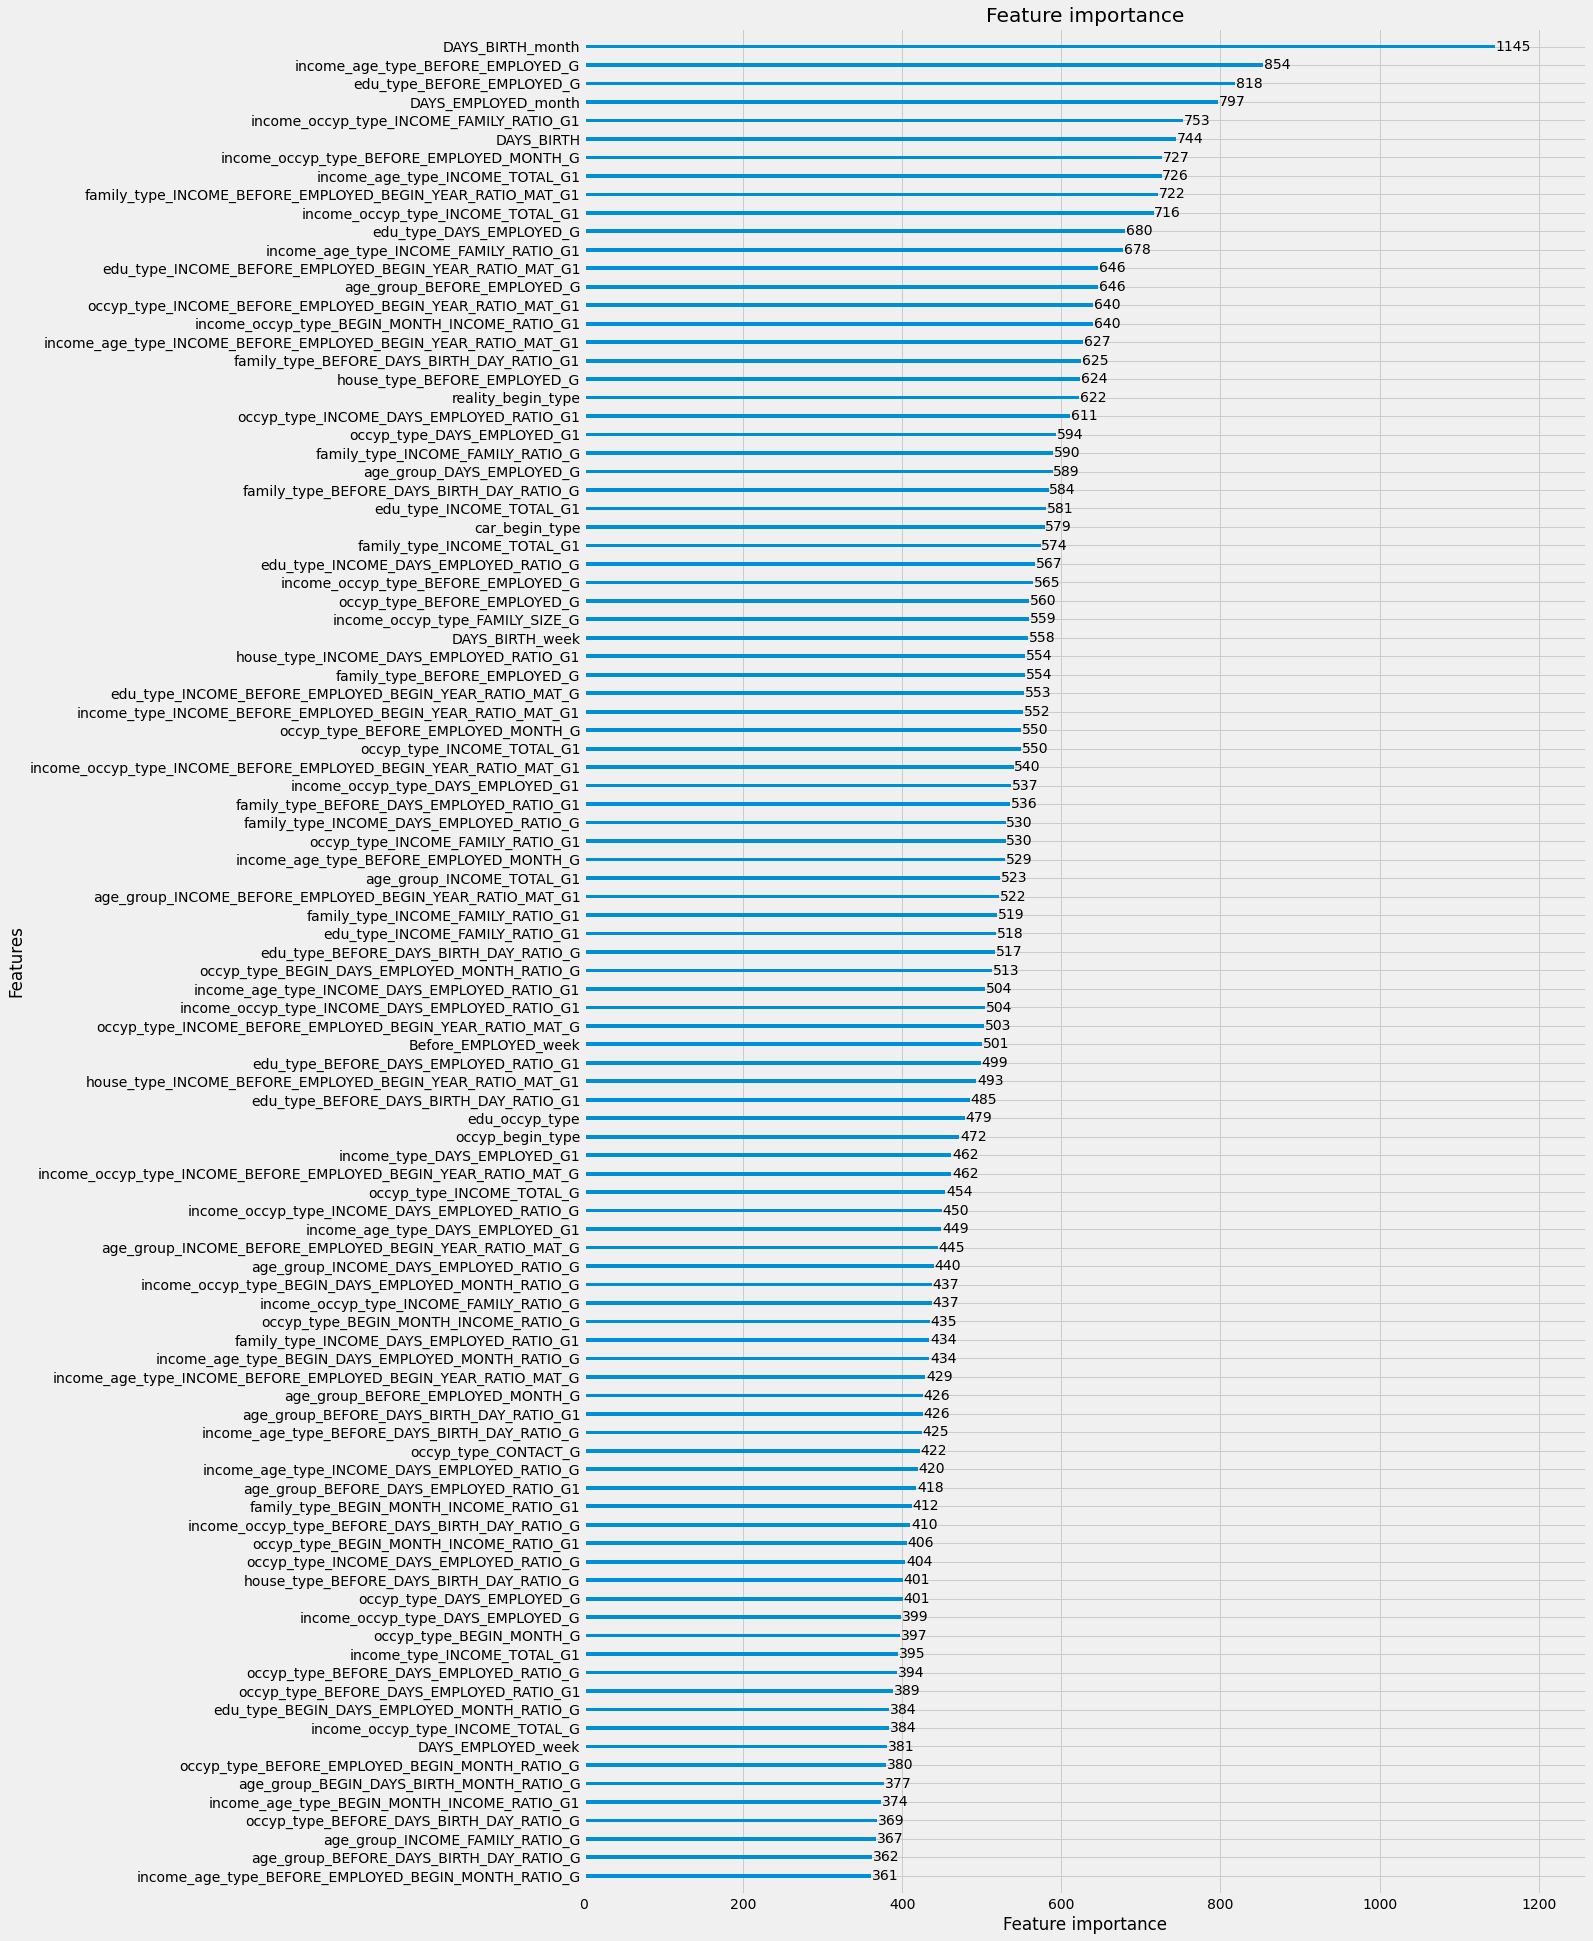

In [88]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)

#### Feature Selection & Cross Validation

In [610]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(clf, threshold='mean')
smf.fit(ftr, target)
X_new = smf.transform(ftr)
X_te_new = smf.transform(X_tst)
feature_idx = smf.get_support()
feature_name = ftr.columns[feature_idx]

In [611]:
feature_name

Index([                                'DAYS_BIRTH',
                                  'DAYS_BIRTH_year',
                                 'DAYS_BIRTH_month',
                                  'DAYS_BIRTH_week',
                              'DAYS_EMPLOYED_month',
                               'DAYS_EMPLOYED_week',
                             'Before_EMPLOYED_week',
                         'age_group_INCOME_TOTAL_G',
                        'age_group_INCOME_TOTAL_G1',
                        'age_group_DAYS_EMPLOYED_G',
       ...
           'edu_type_BEFORE_DAYS_EMPLOYED_RATIO_G1',
       'edu_type_BEGIN_DAYS_EMPLOYED_MONTH_RATIO_G',
                                                  1,
                                                  3,
                                                  7,
                                                  8,
                                                 16,
                                                 23,
                                   

In [612]:
X_new = pd.DataFrame(X_new)
X_te_new = pd.DataFrame(X_te_new)

X_new.columns = feature_name
X_te_new.columns = feature_name

In [613]:
X_new.shape

(26457, 154)

In [89]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, ftr, target, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))
# no feature engineering : -0.7431
# mean - 7246
# 2.0*mean - 7225

교차 검증별 정확도: [-0.7263 -0.7243 -0.7301 -0.7298 -0.7245]
평균 검증 정확도: -0.727


#### Bayesian Opt

In [90]:
ftr = X
target = y

In [91]:
from bayes_opt import BayesianOptimization

In [92]:
train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 369), (7938, 369))

In [93]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [94]:
def lgb_log_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', verbose=100, 
                early_stopping_rounds=100)
    valid_pred = lgb_model.predict_proba(valid_x)
    log_score = log_loss(valid_y, valid_pred)
    
    return log_score

In [95]:
lgbBO = BayesianOptimization(f=lgb_log_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.779531	valid_1's multi_logloss: 0.800626
[200]	training's multi_logloss: 0.733692	valid_1's multi_logloss: 0.779627
[300]	training's multi_logloss: 0.70003	valid_1's multi_logloss: 0.767373
[400]	training's multi_logloss: 0.674148	valid_1's multi_logloss: 0.759561
[500]	training's multi_logloss: 0.655399	valid_1's multi_logloss: 0.754965
[600]	training's multi_logloss: 0.64107	valid_1's multi_logloss: 0.752001
[700]	training's multi_logloss: 0.631231	valid_1's multi_logloss: 0.75027
[800]	training's multi_logloss: 0.623005	valid_1's multi_logloss: 0.748902
[900]	training's multi_logloss: 0.615679	valid_1's multi_logloss: 0.74772

[600]	training's multi_logloss: 0.770877	valid_1's multi_logloss: 0.792722
[700]	training's multi_logloss: 0.770478	valid_1's multi_logloss: 0.792556
[800]	training's multi_logloss: 0.770469	valid_1's multi_logloss: 0.792554
Early stopping, best iteration is:
[709]	training's multi_logloss: 0.770471	valid_1's multi_logloss: 0.792554
|  8        |  0.7926   |  0.9814   |  60.23    |  16.0     |  200.0    |  50.0     |  24.0     |  50.0     |  10.0     |  0.6444   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.806992	valid_1's multi_logloss: 0.813014
[200]	training's multi_logloss: 0.786733	valid_1's multi_logloss: 0.801097
[300]	training's multi_logloss: 0.776856	valid_1's multi_logloss: 0.796219
[400]	training's multi_logloss: 0.77305	valid_1's multi_logloss: 0.794626
[500]	training's multi_logloss: 0.770544	valid_1's multi_logloss: 0.793677
[600]	training's multi_logloss: 0.769691	valid_1's multi_logloss: 0.793332
[700]	training's mul

[400]	training's multi_logloss: 0.763338	valid_1's multi_logloss: 0.790996
[500]	training's multi_logloss: 0.761014	valid_1's multi_logloss: 0.790252
[600]	training's multi_logloss: 0.760306	valid_1's multi_logloss: 0.789998
[700]	training's multi_logloss: 0.760247	valid_1's multi_logloss: 0.78999
Early stopping, best iteration is:
[644]	training's multi_logloss: 0.760247	valid_1's multi_logloss: 0.78999
|  16       |  0.79     |  0.7565   |  10.58    |  9.588    |  17.31    |  1.538    |  54.66    |  48.19    |  6.681    |  0.7388   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.806361	valid_1's multi_logloss: 0.811535
[200]	training's multi_logloss: 0.785328	valid_1's multi_logloss: 0.799013
[300]	training's multi_logloss: 0.772016	valid_1's multi_logloss: 0.792536
[400]	training's multi_logloss: 0.765633	valid_1's multi_logloss: 0.789706
[500]	training's multi_logloss: 0.763034	valid_1's multi_logloss: 0.788714
[600]	training's mult

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.808577	valid_1's multi_logloss: 0.812447
[200]	training's multi_logloss: 0.78931	valid_1's multi_logloss: 0.800615
[300]	training's multi_logloss: 0.777659	valid_1's multi_logloss: 0.794725
[400]	training's multi_logloss: 0.772683	valid_1's multi_logloss: 0.792416
[500]	training's multi_logloss: 0.770139	valid_1's multi_logloss: 0.791485
[600]	training's multi_logloss: 0.768932	valid_1's multi_logloss: 0.79101
[700]	training's multi_logloss: 0.768616	valid_1's multi_logloss: 0.790866
Early stopping, best iteration is:
[654]	training's multi_logloss: 0.768617	valid_1's multi_logloss: 0.790866
|  24       |  0.7909   |  0.506    |  322.6    |  8.331    |  139.7    |  31.98    |  39.04    |  46.29    |  5.429    |  0.6082   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.807901	valid_1's multi_logloss: 0.812572
[200]	training's multi_logloss: 0.

|  30       |  0.7947   |  0.5      |  500.0    |  8.0      |  10.0     |  1.0      |  24.0     |  50.0     |  10.0     |  0.5      |


In [96]:
lgbBO.res

[{'target': 0.7469896817688995,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 0.7327106124446248,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 0.7292714668948251,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.6124

In [97]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('minimum target index:', np.argmin(np.array(target_list)))

[0.7469896817688995, 0.7327106124446248, 0.7292714668948251, 0.7599038191491595, 0.7716666792793783, 0.7917690384025536, 0.7926194351869704, 0.7925536037944529, 0.7933221341906697, 0.7349034889959263, 0.7902863513641478, 0.7921819735893724, 0.7766668224646803, 0.7920660894472356, 0.7867591116000657, 0.7899902242624666, 0.787997704059328, 0.7940221137245157, 0.7741934697852135, 0.7289024699586559, 0.7901162808277152, 0.7762786134526023, 0.7844776845534884, 0.7908662212818526, 0.7928137656791341, 0.7930701121706544, 0.7913740672525296, 0.7942512585549675, 0.7946206968956584, 0.7947435928738349]
minimum target index: 19


In [98]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
min_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(min_dict)

{'target': 0.7289024699586559, 'params': {'colsample_bytree': 0.5, 'max_bin': 113.05580692702318, 'max_depth': 8.0, 'min_child_samples': 10.0, 'min_child_weight': 1.0, 'num_leaves': 64.0, 'reg_alpha': 0.01, 'reg_lambda': 10.0, 'subsample': 1.0}}


In [99]:
ftr = X
target = y

In [102]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros(ftr.shape[0])
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((X_tst.shape[0], 3))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMClassifier(
                n_jobs=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=8,
                num_leaves=64,
                colsample_bytree=0.5,
                subsample=1.0,
                max_bin=113,
                reg_alpha=0.01,
                reg_lambda=10.0,
                min_child_weight=1.0,
                min_child_samples=10,
                silent=-1,
                verbose=-1,
                )
    
    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration', fold_idx, '시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 200, 
                early_stopping_rounds= 200)
        
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]    
        
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산.
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(X_tst, num_iteration=clf.best_iteration_)/folds.n_splits
             
    return clf, test_preds

In [103]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration 0 시작
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.738546	valid_1's multi_logloss: 0.789938
[400]	training's multi_logloss: 0.678597	valid_1's multi_logloss: 0.767204
[600]	training's multi_logloss: 0.634485	valid_1's multi_logloss: 0.75349
[800]	training's multi_logloss: 0.598288	valid_1's multi_logloss: 0.743775
[1000]	training's multi_logloss: 0.56606	valid_1's multi_logloss: 0.737329
[1200]	training's multi_logloss: 0.538319	valid_1's multi_logloss: 0.733165
[1400]	training's multi_logloss: 0.513293	valid_1's multi_logloss: 0.730634
[1600]	training's multi_logloss: 0.488428	valid_1's multi_logloss: 0.728463
[1800]	training's multi_logloss: 0.466763	valid_1's multi_logloss: 0.727231
[2000]	training's multi_logloss: 0.445887	valid_1's multi_logloss: 0.726605
[2200]	training's multi_logloss: 0.426218	valid_1's multi_logloss: 0.726637
Early stopping, best iteration is:
[2025]	training's multi_logloss: 0.443395	valid_1's 

In [104]:
sub[sub.columns] = test_preds
sub.head()

,0,1,2
index,,,
26457,0.064543,0.133317,0.802141
26458,0.121161,0.214535,0.664304
26459,0.049306,0.113941,0.836754
26460,0.098419,0.113827,0.787754
26461,0.152089,0.202104,0.645807


In [105]:
sub.to_csv('0524(groupby).csv')

### catboost

In [628]:
X = X_new
X_tst = X_te_new
y = trn['credit']

In [629]:
ftr = X
target = y

In [630]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 154), (7938, 154))

In [631]:
from catboost import CatBoostClassifier

In [632]:
clf = CatBoostClassifier(
    iterations=2000, 
    learning_rate=0.01, 
    loss_function='multilogloss'
)

In [633]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0], 3))
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((X_tst.shape[0], 3))
    
    # n_estimators를 4000까지 확대. 
    clf = CatBoostClassifier(random_state=0, iterations=4000, eval_metric='MultiClass')

    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration', fold_idx, '시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], verbose= 200, 
                early_stopping_rounds= 200)
        
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        oof_preds[valid_idx] = clf.predict_proba(valid_x)   
        
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산.
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(X_tst)/folds.n_splits
             
    return clf, test_preds

In [634]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration 0 시작
Learning rate set to 0.067585
0:	learn: 1.0598927	test: 1.0598927	test1: 1.0598733	best: 1.0598733 (0)	total: 198ms	remaining: 13m 11s
200:	learn: 0.7434472	test: 0.7434472	test1: 0.7819491	best: 0.7819491 (200)	total: 10.6s	remaining: 3m 20s
400:	learn: 0.6826662	test: 0.6826662	test1: 0.7614106	best: 0.7614106 (400)	total: 20.9s	remaining: 3m 7s
600:	learn: 0.6362757	test: 0.6362757	test1: 0.7495502	best: 0.7495502 (600)	total: 31.3s	remaining: 2m 56s
800:	learn: 0.5980549	test: 0.5980549	test1: 0.7421751	best: 0.7421751 (800)	total: 43.3s	remaining: 2m 53s
1000:	learn: 0.5671783	test: 0.5671783	test1: 0.7371892	best: 0.7371892 (1000)	total: 53.8s	remaining: 2m 41s
1200:	learn: 0.5405990	test: 0.5405990	test1: 0.7346087	best: 0.7346040 (1199)	total: 1m 4s	remaining: 2m 30s
1400:	learn: 0.5161596	test: 0.5161596	test1: 0.7322747	best: 0.7322126 (1390)	total: 1m 15s	remaining: 2m 19s
1600:	learn: 0.4927935	test: 0.4927935	test1: 0.7311496	best: 0.7309118 (1569)	tot

In [637]:
test_preds.shape

(10000, 3)

In [638]:
sub[sub.columns] = test_preds
sub.head()

,0,1,2
index,,,
26457,0.102026,0.107917,0.790057
26458,0.121674,0.176905,0.701422
26459,0.044514,0.090576,0.864909
26460,0.068593,0.115904,0.815503
26461,0.142640,0.221847,0.635513


In [639]:
sub.to_csv('0523_cat.csv')

In [640]:
a = pd.read_csv('0523(groupby)2.csv')
b = pd.read_csv('0523_cat.csv')

FileNotFoundError: [Errno 2] No such file or directory: '0523(groupby)2.csv'